In [1]:
train_path = "../../data/train_preprocessed.json"
test_path = "../../data/test.json"

In [2]:
import sys
sys.path.append('../')
from utils import read_dataset
import tensorflow as tf
import numpy as np
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization, Flatten, Concatenate
from tensorflow.keras import Input, Model
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall
import seaborn as sns

In [3]:
inputs_train, y_train, inputs_test, y_test, user_max, book_max = read_dataset(train_path, test_path, only_mlp=True, balance_test=True)

In [4]:
print(f"Train set: {y_train.sum()/y_train.shape[0]:.4f}")
print(f"Test set : {y_test.sum()/y_test.shape[0]:.4f}")

Train set: 0.4639
Test set : 0.3948


In [5]:
def MLP_model(user_max, book_max, user_emb_size=12, book_emb_size=12):
    user_id_input = Input(shape=(1,), name="user_id")
    book_id_input = Input(shape=(1,), name="book_id")
    numerics_input = Input(shape=(3,), name="numerics")

    user_embedding = Embedding(input_dim=user_max + 3, output_dim=user_emb_size, input_length=1, name="user_embedding")(user_id_input)
    book_embedding = Embedding(input_dim=book_max + 3, output_dim=book_emb_size, input_length=1, name="book_embedding")(book_id_input)

    user_flattened = Flatten()(user_embedding)
    book_flattened = Flatten()(book_embedding)

    numerics = Sequential([
        Dense(40, activation="relu"),
        BatchNormalization(),
        Dropout(0.5)
    ])(numerics_input)

    concatenated = Concatenate()([user_flattened, book_flattened, numerics])

    out = BatchNormalization()(Dense(256, activation="relu")(concatenated))
    out = Dropout(0.5)(out)
    out = BatchNormalization()(Dense(64, activation="relu")(out))
    out = Dense(1, activation="sigmoid")(out)


    model = Model(inputs=[user_id_input, book_id_input, numerics_input], outputs=out)
    return model

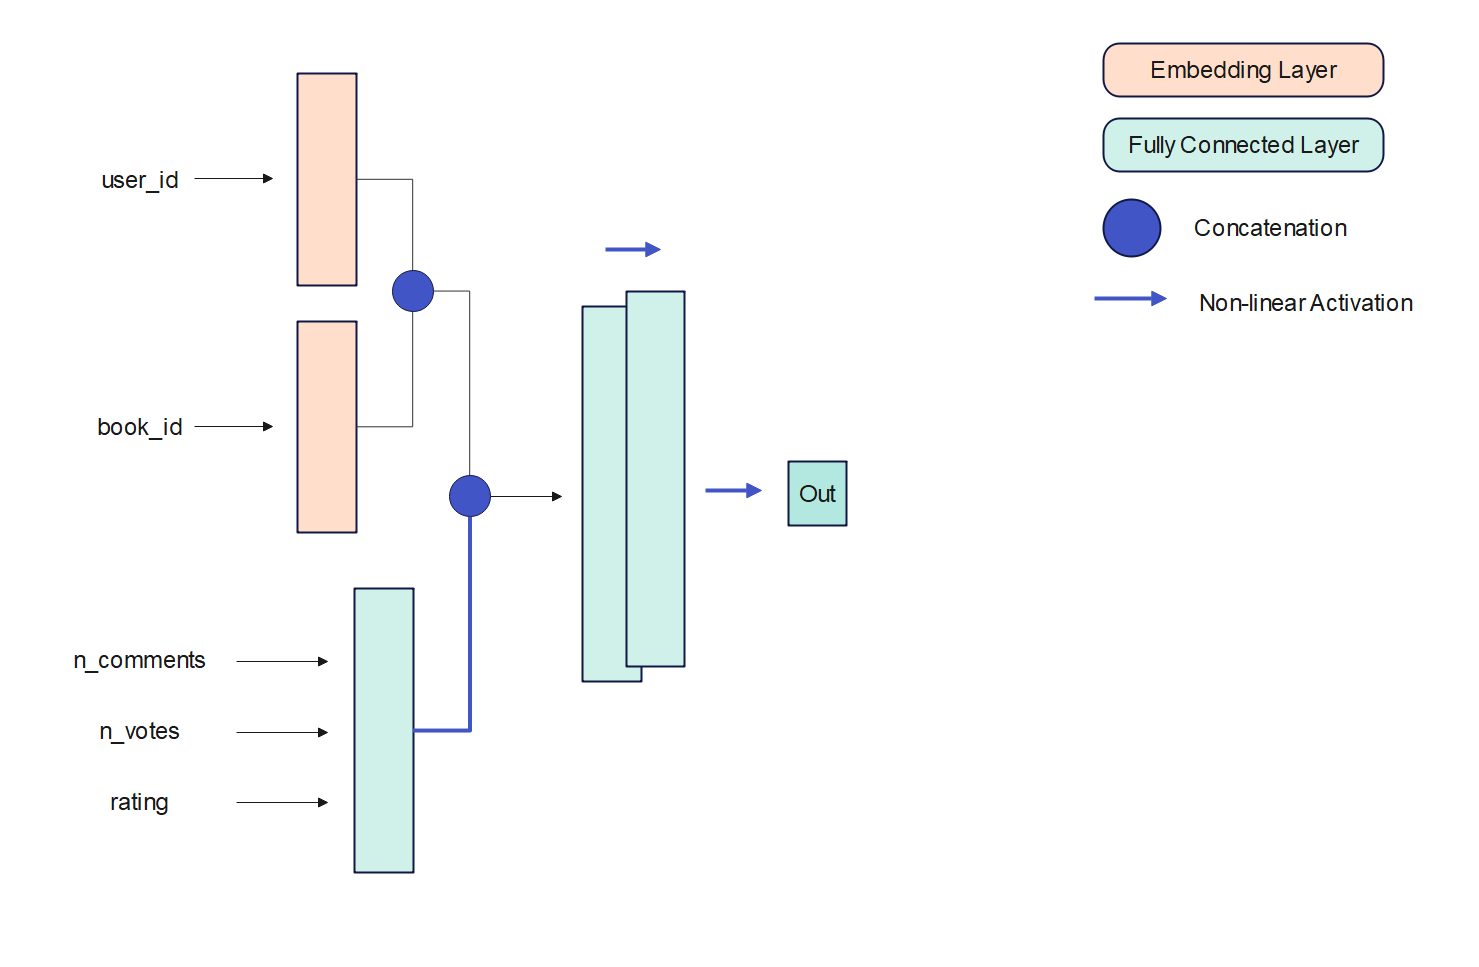

**Note:** In the code, we concatenated all feature at once, however this doesn't make any difference.

In [10]:
model = MLP_model(user_max, book_max, user_emb_size=24, book_emb_size=16)

# We used the simplest learning rate scheduler, because it works well
def scheduler(epoch, lr=1e-4):
    if epoch < 4:
        return lr
    else:
        return 1e-6

lr_scheduler = LearningRateScheduler(scheduler)

In [11]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC()])
model.fit(inputs_train, y_train, validation_split=0.2, epochs=6, batch_size=256,callbacks=[lr_scheduler])

Epoch 1/6
350/350 [==============================] - 3s 5ms/step - loss: 0.7084 - auc_1: 0.5335 - val_loss: 0.6877 - val_auc_1: 0.5536 - lr: 0.0010
Epoch 2/6
350/350 [==============================] - 2s 5ms/step - loss: 0.6770 - auc_1: 0.5942 - val_loss: 0.6267 - val_auc_1: 0.7209 - lr: 0.0010
Epoch 3/6
350/350 [==============================] - 2s 5ms/step - loss: 0.5865 - auc_1: 0.7537 - val_loss: 0.5800 - val_auc_1: 0.7627 - lr: 0.0010
Epoch 4/6
350/350 [==============================] - 2s 5ms/step - loss: 0.5301 - auc_1: 0.8115 - val_loss: 0.5803 - val_auc_1: 0.7693 - lr: 0.0010
Epoch 5/6
350/350 [==============================] - 2s 5ms/step - loss: 0.4932 - auc_1: 0.8417 - val_loss: 0.5798 - val_auc_1: 0.7691 - lr: 1.0000e-06
Epoch 6/6
350/350 [==============================] - 2s 5ms/step - loss: 0.4927 - auc_1: 0.8419 - val_loss: 0.5798 - val_auc_1: 0.7691 - lr: 1.0000e-06


In [12]:
preds = model.predict(inputs_test, batch_size=512, verbose=0)

# selects best threshold value
thresholds = np.linspace(0,0.5,100)
best = 0
best_th = None
for th in thresholds:
    f1 = f1_score(y_test, (preds>th).astype(int))
    if f1 > best:
        best = f1
        best_th = th
        
binary_preds = (preds > best_th).astype(int)
print(f"threshold: {best_th}")
print(f"Precision: {precision_score(binary_preds, y_test)}")
print(f"Recall:    {recall_score(binary_preds, y_test)}")
print(f"F1 score:  {best}")
print(f"AUC score: {roc_auc_score(binary_preds, y_test)}")

threshold: 0.37878787878787884
Precision: 0.7906638049977004
Recall:    0.5528459641976632
F1 score:  0.6507065354529398
AUC score: 0.6815175053126208


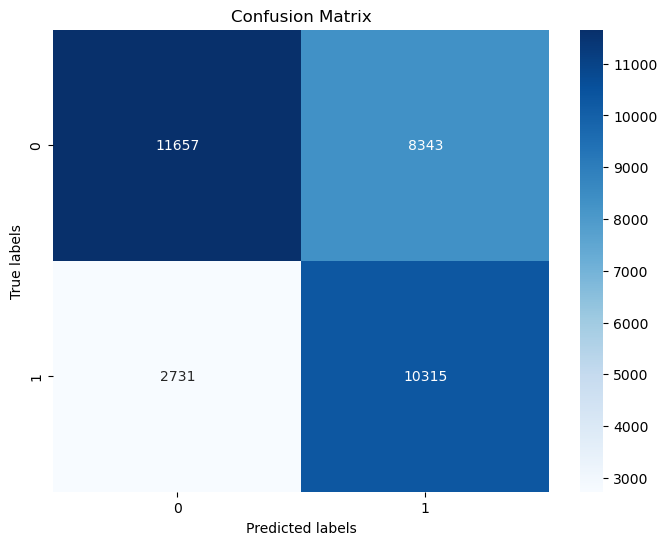

In [13]:
# Getting the confusion matrix
conf_matrix = confusion_matrix(y_test, (preds>best_th).astype(int))

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [24]:
model.save_weights("../pretrained_models/mlp_model.h5")